<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/%E6%99%82%E7%B3%BB%E5%88%97%E6%A0%AA%E4%BE%A1%E4%BA%88%E6%B8%ACgit%E7%94%A8%E3%81%9D%E3%81%AE%EF%BC%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 問題
- LSTMを用いて<font color="red">終値</font>の予測を行えと。
- 予測精度をRMSEを用いて計測。小さくなるようにするべし。


<font color="red">ポイント</font>

・時系列データのLSTM解析。LSTMの都合上、大部分のデータをpandasではなく<font color="red">numpy</font>で行う。⇒面喰った。pandasに慣れているので。

・データ分析の定石、時系列カラムをdatetime形式にしてindexにぶち込む。⇒今回は不要。

pandas/dfで扱う際は有効だけど、今回はnumpuyなので。

### データ読み込み

データの確認。確認してみると末尾に不要なデータがありそうですね。

In [48]:
import pandas as pd
# データの読込
df = pd.read_csv("/content/nikkei225.csv")
df

,日付け,終値,始値,高値,安値,出来高,前日比%
0,2017年01月31日,18980,19350,19390,18970,82.98K,-1.81
1,2017年01月30日,19330,19500,19560,19280,48.95K,-0.67
2,2017年01月27日,19460,19450,19560,19390,63.14K,0.00
3,2017年01月26日,19460,19070,19460,19050,74.06K,2.05
4,2017年01月25日,19070,18850,19130,18830,61.89K,1.22
...,...,...,...,...,...,...,...
2061,2009年03月06日,7170,7400,7440,7150,91.24K,-3.24
2062,2009年03月05日,7410,7310,7540,7290,114.64K,1.93
2063,2009年03月04日,7270,7200,7320,7090,79.49K,0.83
2064,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# 確認した所、カラム"日付け"に時系列情報があります。これをindexに格納しましょう。
df = pd.read_csv("/content/nikkei225.csv",index_col='日付け')
df

,終値,始値,高値,安値,出来高,前日比%
日付け,,,,,,
2017年01月31日,18980,19350,19390,18970,82.98K,-1.81
2017年01月30日,19330,19500,19560,19280,48.95K,-0.67
2017年01月27日,19460,19450,19560,19390,63.14K,0.00
2017年01月26日,19460,19070,19460,19050,74.06K,2.05
2017年01月25日,19070,18850,19130,18830,61.89K,1.22
...,...,...,...,...,...,...
2009年03月06日,7170,7400,7440,7150,91.24K,-3.24
2009年03月05日,7410,7310,7540,7290,114.64K,1.93
2009年03月04日,7270,7200,7320,7090,79.49K,0.83


そしてdfの末尾に余計なものがありますのでカットもしておきましょう。

skipfooter：下から数行を読み飛ばす。　[詳細はこちら](https://www.yutaka-note.com/entry/pandas_read_csv#skipfooter%E4%B8%8B%E3%81%8B%E3%82%89%E6%95%B0%E8%A1%8C%E3%82%92%E8%AA%AD%E3%81%BF%E9%A3%9B%E3%81%B0%E3%81%99)

In [50]:
# データセットの読み込み、かつ末尾をカット。
df = pd.read_csv('/content/nikkei225.csv',
                        # usecols=[1],              #読み込む列を指定
                        engine='python', 
                        skipfooter=2                # ここが大事。
                        )
df

,日付け,終値,始値,高値,安値,出来高,前日比%
0,2017年01月31日,18980.0,19350.0,19390.0,18970.0,82.98K,-1.81
1,2017年01月30日,19330.0,19500.0,19560.0,19280.0,48.95K,-0.67
2,2017年01月27日,19460.0,19450.0,19560.0,19390.0,63.14K,0.00
3,2017年01月26日,19460.0,19070.0,19460.0,19050.0,74.06K,2.05
4,2017年01月25日,19070.0,18850.0,19130.0,18830.0,61.89K,1.22
...,...,...,...,...,...,...,...
2059,2009年03月10日,7040.0,7050.0,7110.0,6960.0,85.37K,-0.14
2060,2009年03月09日,7050.0,7180.0,7230.0,7020.0,74.47K,-1.67
2061,2009年03月06日,7170.0,7400.0,7440.0,7150.0,91.24K,-3.24
2062,2009年03月05日,7410.0,7310.0,7540.0,7290.0,114.64K,1.93


今回は終値の予測なので終値以外のデータを削除致します。

他のカラム(高値/安値/出来高)も変数に使えるかなと思ったのですが、<font color="red">株価予測</font>なので正直分からないです…。是非試してください。

In [51]:
df = df[["終値"]]
df

,終値
0,18980.0
1,19330.0
2,19460.0
3,19460.0
4,19070.0
...,...
2059,7040.0
2060,7050.0
2061,7170.0
2062,7410.0


欠損値の確認もしておきましょう。⇒大丈夫そうですね。

In [52]:
df.dtypes
df.isnull().sum()

終値    0
dtype: int64

### [データ分割](https://premium.aidemy.jp/courses/6160/exercises/ZkSMBMEp7K)
前半67%(2/3)を訓練データに、後半33%(1/3)を検証データに分割

訓練データは機械学習モデルの学習（調整）を行うためのデータ。

テストデータはモデルの予測結果の精度を評価するデータ。

今回は比較的シンプルな分割方法を用います。


In [53]:
#データ分割。シンプルに２つに分ける。
#訓練データ、テストデータは2:1になるように。

train =df[:int(len(df)*0.67)] # この長さまで。
test  =df[int(len(df)*0.67):] # この長さ以降。

print(len(df), len(train), len(test))

2064 1382 682


### [データスケーリング](https://premium.aidemy.jp/courses/6160/exercises/NpMLLgDLXX)

単位や値の範囲が異なるデータをある基準で均一化して尺度を揃える

今回は正規化

年齢と年収の場合で、

年齢：0〜100程度の値

年収は0〜1億など広範囲の値。

これらの値をそのまま使ってしまうと年齢に対して年収の値が圧倒的に大きな影響を持ってしまう。⇒うまく学習できないといった現象に。
　⇒これを防ぐための<font color="red">スケーリング</font>

スケーリングの手段⇒正規化と標準化

<font color="red">正規化</font>（MinMaxScaler）：最低値が0、最高値が1になるように値を変換。

<font color="red">標準化</font>（StandardScaler）は平均が0、標準偏差が1になるように元の値を変換。

機械学習ではスケーリングは<font color="red">訓練データのみ</font>を基準に行います。

下記の例を参照。トレインデータを基準として、トレインとテストを正規化。

In [54]:
# データのスケーリング（正規化）⇒最小値が0, 最大値が1となるようにする。
# MinMaxScaler()は、データをfeature_rangeで指定した範囲内(今回は0～1)に正規化するモジュール

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


# トレインデータを基準とします。
scaler_train = scaler.fit(train)
# パラメータを用いて`train`データをスケーリングします
train = scaler_train.transform(train)
# パラメータを用いて`test`データをスケーリングします
test = scaler_train.transform(test)

### [入力データ・正解ラベルの作成](https://premium.aidemy.jp/courses/6160/exercises/SOTuOSnQ2Y)
<font color="red">look_back = nのn</font>がいくつ前のデータまで利用するか。
　どのくらい前までのデータを利用するのですか？という事。

この例だと、基準点含めて３つ前までのデータを利用して次を予測します。という事

train⇒train_X, train_Y

test ⇒test_X, test_Y


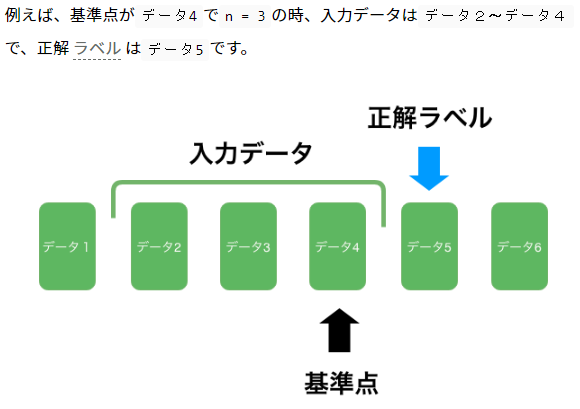

In [55]:
# LSTn用の入力データ・正解ラベルの作成　独自関数を作成。
# 引数に look_back,dataset
import numpy as np

def create_dataset(dataset, look_back):
    data_X, data_Y = [], []
    for i in range(look_back, len(dataset)):
        data_X.append(dataset[i-look_back:i, 0])
        data_Y.append(dataset[i, 0])
    return np.array(data_X), np.array(data_Y)

In [56]:
# その独自関数の呼び出し
look_back = 5

train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# 試しに train_X を確認。可視化の為にdf化して。
train_X_df = pd.DataFrame(train_X)
train_X_df

,0,1,2,3,4
0,0.853312,0.880915,0.891167,0.891167,0.860410
1,0.880915,0.891167,0.891167,0.860410,0.842271
2,0.891167,0.891167,0.860410,0.842271,0.848580
3,0.891167,0.860410,0.842271,0.848580,0.867508
4,0.860410,0.842271,0.848580,0.867508,0.862776
...,...,...,...,...,...
1372,0.026814,0.026025,0.044953,0.040221,0.047319
1373,0.026025,0.044953,0.040221,0.047319,0.050473
1374,0.044953,0.040221,0.047319,0.050473,0.049487
1375,0.040221,0.047319,0.050473,0.049487,0.041798


look backが5つなんで、5列あるという訳ですね。

そして時系列なので斜めが同じ数値になっている。⇒一つづつズレている。という事に着目。

In [57]:
train_X.shape,train_Y.shape,test_X.shape,test_Y.shape

((1377, 5), (1377,), (677, 5), (677,))

### [データ整形](https://premium.aidemy.jp/courses/6160/exercises/3xXX8qwu7-)
作成したデータはLSTMで分析できるデータ形式ではない⇒入力データの整形。

入力データを<font color="red">行数×変数数×カラム数</font>の3次元の行列に変換、LSTMで分析できるデータ形式に整形する。

- 行数：データの総数 　　　　　　　　　　　　　入力データの総数1377
- 変数数：1セットのデータに含まれる要素数　　１セットの入力データに含まれる要素数、つまりlook_backで指定した5
- カラム数：扱うデータの種別数　　　　　　　　終値のみを扱うので1

そのままの意味での変数数、カラム数とは違うので混乱するかもしれませんが、
<font color="red">行数×look_back数×当初の変数</font>これでいかがでしょうか。

reshapeメソッドを用いて、データを指定した形式の行列に変換します。

In [58]:
print("train_X.shape[0]:",train_X.shape[0],"train_X.shape[1]:",train_X.shape[1])

train_X.shape[0]: 1377 train_X.shape[1]: 5


In [59]:
# 3次元のnumpy.ndarrayに変換します⇒ reshapeでLSTN用に変換している。
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

### [LSTMネットワークの構築と訓練](https://premium.aidemy.jp/courses/6160/exercises/mRBWTDAXqs)

、LSTMネットワークを構築し、これまでに用意したデータを用いてモデルの訓練（学習）と予測、評価

いくつか学習モデルを構築し試行錯誤致しました。

#### 1回目の学習

6行目のレイヤーはモデルの最初のレイヤーのため、引数input_shapeを指定します。以降の層では、引数input_shapeは指定しない。

出力層：モデル最後のレイヤー：出力結果を吐き出す物。
1つのノードを持つ全結合層を追加します。

訓練過程における損失関数（loss）と最適化アルゴリズム（optimizer）の定義

正解ラベルと出力の誤差がより小さくなるように。⇒損失関数の値が小さいほど予測が正確。

分類：categorical_crossentropy

回帰：mean_squared_error

最適化アルゴリズムとは、損失関数の値を減少させるように、重みを更新するアルゴリズム。

どれが有効化は分からないので、毎度確認していく。

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTMモデルの作成｡
model = keras.Sequential()                                                      
model.add(layers.LSTM(8, input_shape=(look_back, 1))) # 8つのLSTMブロックからなるレイヤー(層)を追加。
model.add(layers.Dense(1))                                                   # 出力層だから今回は１固定。

model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
# ハイパーパラメータ
batch_size = 16  # バッチサイズ 32,64,128,256,512 あたり
epochs = 20       # エポック数(学習の繰り返し回数)
val_split = 0.3   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。

In [62]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history = model.fit(train_X, 
                    train_Y, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/20
61/61 [==============================] - 3s 14ms/step - loss: 0.1363 - val_loss: 0.0227
Epoch 2/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0383
Epoch 3/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0348
Epoch 4/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0303
Epoch 5/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0253
Epoch 6/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0211
Epoch 7/20
61/61 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0178
Epoch 8/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0145
Epoch 9/20
61/61 [==============================] - 0s 5ms/step - loss: 9.5872e-04 - val_loss: 0.0126
Epoch 10/20
61/61 [==============================] - 0s 4ms/step - loss: 8.2048e-04 - val_loss: 0.0105
Epoch 11/2

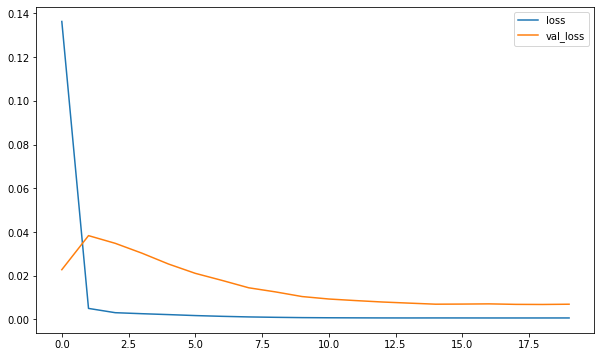

In [63]:
# loss の 学習過程のプロット
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.legend()

#### 1回目を考慮した2回目の学習

これはAidemyの教材通り

64,32という数字はどこから来たのか？何を持って決めたのか？⇒
2の乗数で決まる。

batch_sizeも何をもって決めたのか？

return_sequences=True ⇒LSTNの時系列データで使用する際に引数として使用する。

最後の出力層で model.add(layers.Dense(1)) になるじゃないですか。

それと<font color="red">**くっつくレイヤーにはreturn_sequences=Trueは不要**</font>です。

In [64]:
# LSTMモデルの作成
model2 = keras.Sequential()

model2.add(layers.LSTM(64, input_shape=(look_back, 1), return_sequences=True))
model2.add(layers.LSTM(32,return_sequences=True))

model2.add(layers.LSTM(16,return_sequences=True)) #私が追加しました。
model2.add(layers.LSTM(8)) #私が追加しました。

model2.add(layers.Dense(1))
# モデルをコンパイルしてください
model2.compile(loss='mean_squared_error', optimizer='adam')

In [65]:
# ハイパーパラメータ
batch_size = 32  # バッチサイズ 32,64,128,256,512 あたり
epochs = 30       # エポック数(学習の繰り返し回数)
val_split = 0.3   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。

In [66]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history2 = model2.fit(train_X, 
                    train_Y, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/30
31/31 [==============================] - 9s 69ms/step - loss: 0.2728 - val_loss: 0.1265
Epoch 2/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0195 - val_loss: 0.1159
Epoch 3/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0953
Epoch 4/30
31/31 [==============================] - 1s 16ms/step - loss: 0.0083 - val_loss: 0.0547
Epoch 5/30
31/31 [==============================] - 1s 16ms/step - loss: 0.0037 - val_loss: 0.0263
Epoch 6/30
31/31 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0149
Epoch 7/30
31/31 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0166
Epoch 8/30
31/31 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0155
Epoch 9/30
31/31 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0178
Epoch 10/30
31/31 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0174
Epoch 11/

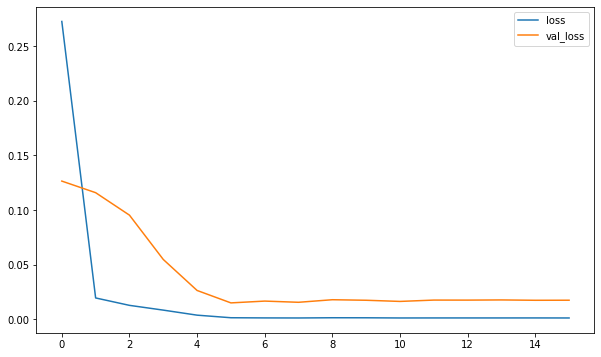

In [67]:
# loss の 学習過程のプロット
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history2.epoch, history2.history["loss"], label="loss")
plt.plot(history2.epoch, history2.history["val_loss"], label="val_loss")

plt.legend()

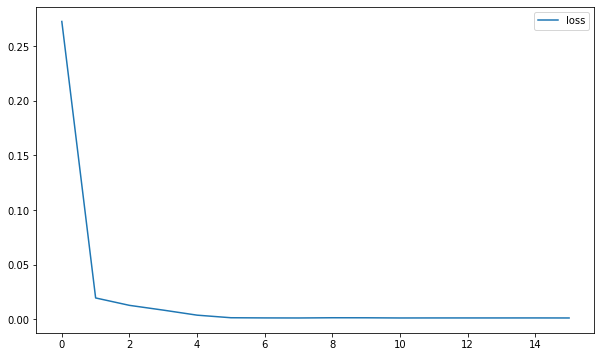

In [68]:
# loss の 学習過程のプロット
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history2.epoch, history2.history["loss"], label="loss")
# plt.plot(history2.epoch, history2.history["val_loss"], label="val_loss")

plt.legend()

#### 3回目の学習
最良

In [69]:
# LSTMモデルを作成してください
model3 = keras.Sequential()
model3.add(layers.LSTM(64, input_shape=(look_back, 1), return_sequences=True))
model3.add(layers.LSTM(32))
model3.add(layers.Dense(1))
# モデルをコンパイルしてください
model3.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
# ハイパーパラメータ
batch_size = 32  # バッチサイズ 32,64,128,256,512 あたり
epochs = 30       # エポック数(学習の繰り返し回数)
val_split = 0.3   # 訓練データのうちx%をvalidation dataとして分割して使います。
pati_time = 10    # y回学習しても向上しない場合は学習を打ち切ります。

In [71]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）

    # 構築したモデルで学習（学習データ:trainのうち、10％を検証データ:validationとして使用）
history3 = model3.fit(train_X, 
                    train_Y, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=val_split,
                        callbacks=[
                            callbacks.EarlyStopping(monitor='val_loss',patience = pati_time),
                            callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
                            ]
                    )

Epoch 1/30
31/31 [==============================] - 5s 38ms/step - loss: 0.1154 - val_loss: 0.0280
Epoch 2/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0047 - val_loss: 0.0269
Epoch 3/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0200
Epoch 4/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0150
Epoch 5/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0099
Epoch 6/30
31/31 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0072
Epoch 7/30
31/31 [==============================] - 0s 11ms/step - loss: 9.2253e-04 - val_loss: 0.0056
Epoch 8/30
31/31 [==============================] - 0s 10ms/step - loss: 8.8635e-04 - val_loss: 0.0048
Epoch 9/30
31/31 [==============================] - 0s 10ms/step - loss: 8.8363e-04 - val_loss: 0.0041
Epoch 10/30
31/31 [==============================] - 0s 10ms/step - loss: 9.0303e-04 - val_loss: 0

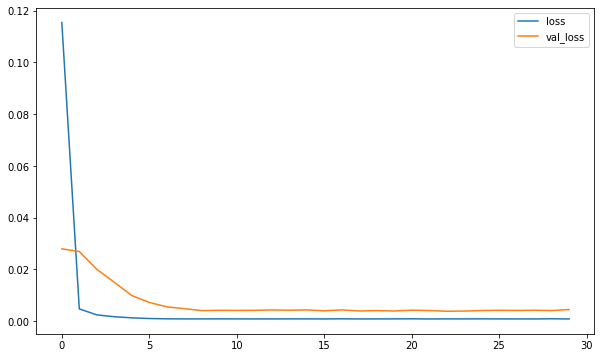

In [72]:
# loss の 学習過程のプロット
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))

plt.plot(history3.epoch, history3.history["loss"], label="loss")
plt.plot(history3.epoch, history3.history["val_loss"], label="val_loss")

plt.legend()

### [データの予測と評価](https://premium.aidemy.jp/courses/6160/exercises/ZNnpEhme53)

#### 正規化を元に戻す
予測したデータや結果を正しく評価、可視化する為の処理ですね。

In [73]:
#予測データの作成
train_predict =model.predict(train_X)
test_predict = model.predict(test_X) 

train_predict2 =model2.predict(train_X)
test_predict2 = model2.predict(test_X) 

train_predict3 =model3.predict(train_X)
test_predict3 = model3.predict(test_X) 


予測データを作成しました。その予測データを正しく評価するには<font color="red">スケーリングしたデータを元に戻す</font>必要があります。

元に戻すには<font color="red">inverse_transform()メソッド</font>

**正規化したらもとに戻す**という手順が必要。

test_Yの整形 ⇒ ちゃんと比較対象を統一させましょう。677行1列なのか、1列677行なのか。

rmseで使用

In [ ]:
# ちゃんと677行１列にする。
print(test_Y.shape)
test_Y = test_Y.reshape(-1,1)

test_Y = scaler_train.inverse_transform(test_Y)
test_Y

算出した予測値の整形

In [75]:
test_predict
test_predict.shape

(677, 1)

In [76]:
test_predict  = scaler_train.inverse_transform(test_predict)
test_predict2 = scaler_train.inverse_transform(test_predict2)
test_predict3 = scaler_train.inverse_transform(test_predict3)
# test_predict4 = scaler_train.inverse_transform(test_predict4)

あまり

#### rmseの算出
ちゃんと双方のデータ形式をそろえる事。

まずはrmse比較する２つのデータの形状を確認して必要ならばそろえる。

その必要があったので揃えます。

In [77]:
# まずはrmse比較する２つのデータの形状を確認して必要ならばそろえる。
test_predict.shape

# test_Y      # これがおかしい。1列29行になってる。　ちゃんと29行1列にしないと。

(677, 1)

In [78]:
# これで変換
import numpy as np
# test_Y = test_Y.reshape(29,1)

# 返還後は確認しましょう。
print(test_predict.shape)
print(test_predict2.shape)
print(test_predict3.shape)
# print(test_predict4.shape)
print(test_Y.shape)

(677, 1)
(677, 1)
(677, 1)
(677, 1)


In [79]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す

print("No1のRMSE",np.sqrt(MSE(test_predict,test_Y)))
print("No2のRMSE",np.sqrt(MSE(test_predict2,test_Y)))
print("No3のRMSE",np.sqrt(MSE(test_predict3,test_Y)))
# print("No4のRMSE",np.sqrt(MSE(test_predict4,test_Y)))

No1のRMSE 969.1095529773291
No2のRMSE 1533.1083266506491
No3のRMSE 793.1628427234114


## [データ可視化](https://premium.aidemy.jp/courses/6160/exercises/9ShLDO1Ukc)
可視化する時もデータを整形する事。

こちら私が可視化したもの。

プロット時にこのようにデータ出力範囲を限定させました。

```
plt.plot(df[1200:], label='dataset',color = "blue")
```

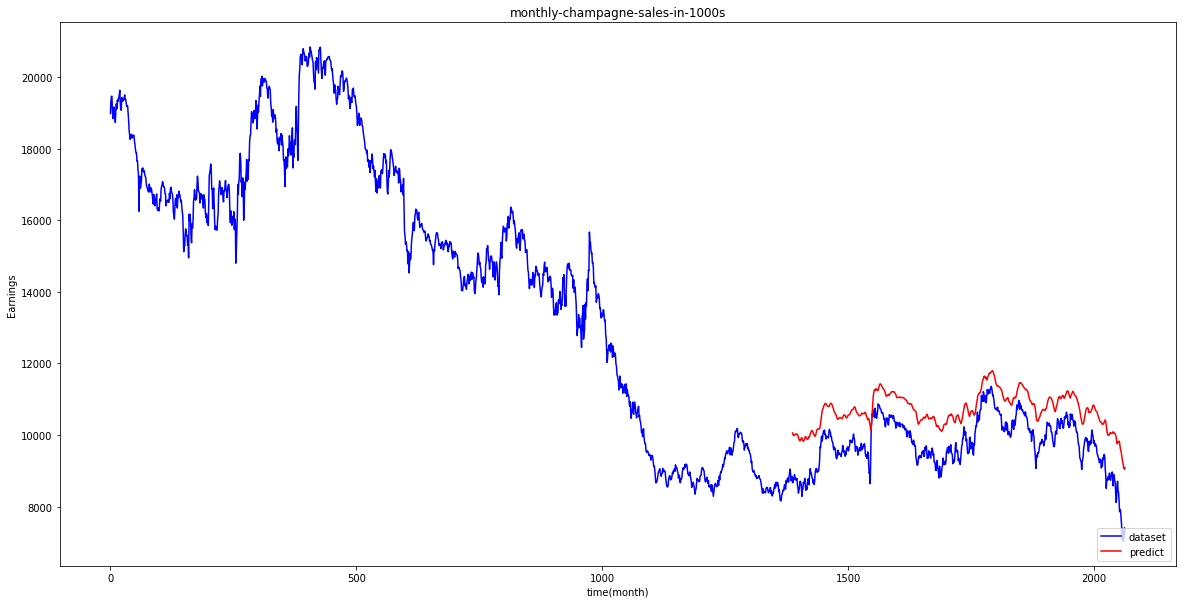

In [84]:
import matplotlib.pyplot as plt
plt.rc("figure",figsize=(20,10))
# 検証データから予測したデータの整形
# 既存の配列`dataset`と同じ大きさ（行数・列数）、データ型で
# 値を０に初期化したプロット用の空の配列を作成します
test_predict_plot = np.empty_like(df)

# 空の配列のすべての値を欠損値`nan`にします
test_predict_plot[:, :] = np.nan

# 訓練データの予測値と位置を合わせます
test_predict_plot[len(train_predict)+(look_back*2):len(df), :] = test_predict

# データのプロット
plt.title("monthly-champagne-sales-in-1000s")
plt.xlabel("time(month)")
plt.ylabel("Earnings")

# 読み込んだままのデータをプロットします
# plt.plot(df, label='dataset',color = "blue")
plt.plot(df, label='dataset',color = "blue")

# 検証データから予測した値をプロットします
plt.plot(test_predict_plot, label='predict',color = "red")

plt.legend(loc='lower right') # 右下に表示しますと。

plt.show()